In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install segmentation-models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install pyyaml h5py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow
import matplotlib.pyplot as plt
from PIL import Image
import glob
from tensorflow.keras import backend as K
import cv2

import os
import random
import numpy as np
from skimage.io import imread, imshow
from skimage.transform import resize
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
from google.colab.patches import cv2_imshow

In [ ]:
path = glob.glob("/content/drive/MyDrive/img600x256X256/*.png")
path.sort()

In [ ]:
train_images = []


for img_path in path:
  img = cv2.imread(img_path,0)
  img = cv2.resize(img, (256, 256),interpolation = cv2.INTER_NEAREST)
  train_images.append(img)

In [ ]:
np.shape(train_images)

(600, 256, 256)

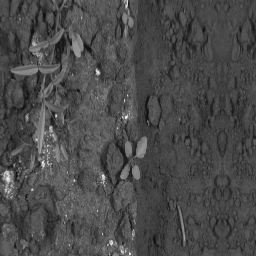

In [ ]:
cv2_imshow(train_images[0])

In [ ]:
path1 = glob.glob("/content/drive/MyDrive/anno256x256/*.png")
path1.sort()

In [ ]:
print(len(path1))

600


In [ ]:
train_masks = []
for img_path1 in path1:
  mask = cv2.imread(img_path1,0)
  mask = cv2.resize(mask, (256, 256), interpolation = cv2.INTER_NEAREST)  #Otherwise ground truth changes due to interpolation
  train_masks.append(mask)

In [ ]:
np.shape(train_masks)

(600, 256, 256)

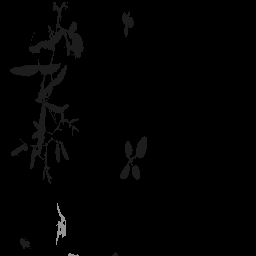

In [ ]:
cv2_imshow(train_masks[0])

In [ ]:
# train_masks = np.expand_dims(train_masks, axis=3)
np.shape(train_masks)

(600, 256, 256)

In [ ]:
n_classes = 3
train_images = np.array(train_images)

train_masks = np.array(train_masks)
np.unique(train_masks)

array([  0,  29, 149], dtype=uint8)

In [ ]:

#Encode labels... but multi dim array so need to flatten, encode and reshape
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = train_masks.shape
train_masks_reshaped = train_masks.reshape(-1,1)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)

np.unique(train_masks_encoded_original_shape)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0, 1, 2])

In [ ]:

#################################################
train_images = np.expand_dims(train_images, axis=3)
train_images = tensorflow.keras.utils.normalize(train_images, axis=1)
train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3)

#Create a subset of data for quick testing
#Picking 10% for testing and remaining for training
from sklearn.model_selection import train_test_split
X1, X_test, y1, y_test = train_test_split(train_images, train_masks_input, test_size = 0.10, random_state = 0)

#Further split training data to smaller subset for quick testing of models
X_train, X_val, y_train, y_val = train_test_split(X1, y1, test_size = 0.20, random_state = 0)

print("Class values in the dataset are ... ", np.unique(y_train))  # 0 is the background/few unlabeled

# from sklearn.utils import to_categorical
import tensorflow as tf

train_masks_cat = tf.keras.utils.to_categorical (y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape(y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes)

val_masks_cat = tf.keras.utils.to_categorical (y_val, num_classes=n_classes)
y_val_cat = val_masks_cat.reshape((y_val.shape[0], y_val.shape[1], y_val.shape[2], n_classes))



# test_masks_cat = tf.keras.utils.to_categorical (y_test, num_classes=n_classes)
# y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))

from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                 classes = np.unique(train_masks_reshaped_encoded),
                                                 y = train_masks_reshaped_encoded)
print("Class weights are...:", class_weights)



Class values in the dataset are ...  [0 1 2]
Class weights are...: [ 0.36058614  5.67928291 19.73984822]


In [ ]:
np.unique(y_train[0])

array([0, 1, 2])

In [ ]:
train_masks_cat

In [ ]:
np.shape(y_val_cat)

In [ ]:
np.unique(y_val_cat)

array([0., 1.], dtype=float32)

In [ ]:
np.shape(y_train_cat)

(432, 256, 256, 3)

In [ ]:
np.shape(y_train)

(432, 256, 256, 1)

In [ ]:
np.shape(train_masks_cat)

(432, 256, 256, 3)

In [ ]:
np.shape(train_images)

(600, 256, 256, 1)

In [ ]:
np.unique(train_masks_input)

array([0, 1, 2])

In [ ]:
np.shape(y1)

(540, 256, 256, 1)

In [ ]:
np.unique(y1)

array([0, 1, 2])

In [ ]:
np.unique(y_val)

array([0, 1, 2])

In [ ]:
np.shape(y_val)

(108, 256, 256, 1)

In [ ]:
np.shape(y_train_cat)

(432, 256, 256, 3)

In [ ]:
np.unique(y_val_cat)

array([0., 1.], dtype=float32)

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras import backend as K



'''
A few useful metrics and losses
'''

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2.0 * intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.0)


def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)


def jacard_coef_loss(y_true, y_pred):
    return -jacard_coef(y_true, y_pred)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)



In [ ]:


from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda




################################################################
def multi_unet_model(n_classes=3, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.8)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.8)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.8)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.8)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.8)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    #Expansive path
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.8)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.8)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.8)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.8)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])

    #NOTE: Compile the model in the main program to make it easy to test with various loss functions
    #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    #model.summary()

    return model


In [ ]:

IMG_HEIGHT = 256
IMG_WIDTH = 256
IMG_CHANNELS = 1
input_shape = (IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS)

In [ ]:
def get_model():
  return multi_unet_model(n_classes= n_classes,IMG_HEIGHT=IMG_HEIGHT,IMG_WIDTH=IMG_WIDTH,IMG_CHANNELS=IMG_CHANNELS)

In [ ]:
model = get_model()


In [ ]:
import segmentation_models as sm
loss_fun = sm.losses.CategoricalFocalLoss(alpha=0.25, gamma=2.0, class_indexes=None)

Segmentation Models: using `keras` framework.


In [ ]:
iou_score = sm.metrics.IOUScore()
Fscore = sm.metrics.FScore()

In [ ]:
model.compile(optimizer='adam',loss = sm.losses.CategoricalFocalLoss(alpha=0.25, gamma=2.0, class_indexes=None),metrics =[iou_score,Fscore] )

In [ ]:
model.summary()

In [ ]:
history = model.fit (X_train,y_train_cat,
                     batch_size = 32,
                     verbose = 1,
                     epochs = 200,
                     validation_data= (X_val,y_val_cat),
                     shuffle = False)

14/14 [==============================] - 5s 330ms/step - loss: 0.0059 - iou_score: 0.3382 - f1-score: 0.4165 - val_loss: 0.0074 - val_iou_score: 0.3349 - val_f1-score: 0.4125
Epoch 174/200
14/14 [==============================] - 5s 331ms/step - loss: 0.0059 - iou_score: 0.3366 - f1-score: 0.4150 - val_loss: 0.0075 - val_iou_score: 0.3371 - val_f1-score: 0.4144
Epoch 175/200
14/14 [==============================] - 5s 354ms/step - loss: 0.0059 - iou_score: 0.3368 - f1-score: 0.4151 - val_loss: 0.0075 - val_iou_score: 0.3376 - val_f1-score: 0.4144
Epoch 176/200
14/14 [==============================] - 5s 354ms/step - loss: 0.0059 - iou_score: 0.3381 - f1-score: 0.4164 - val_loss: 0.0075 - val_iou_score: 0.3387 - val_f1-score: 0.4164
Epoch 177/200
14/14 [==============================] - 5s 331ms/step - loss: 0.0059 - iou_score: 0.3374 - f1-score: 0.4160 - val_loss: 0.0075 - val_iou_score: 0.3395 - val_f1-score: 0.4172
Epoch 178/200
14/14 [==============================] - 5s 332ms/step 

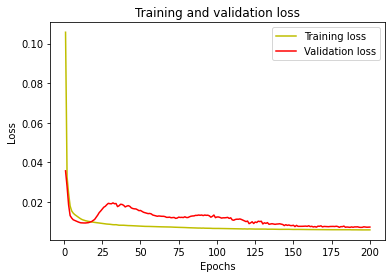

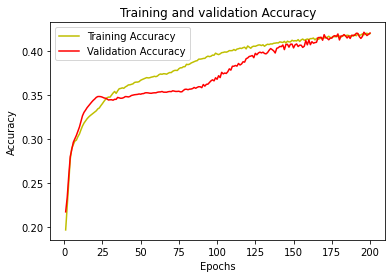

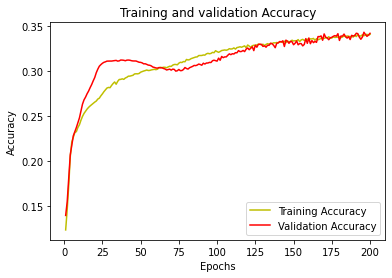

In [ ]:
from keras.utils.version_utils import ModelVersionSelector

###
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['f1-score']
val_acc = history.history['val_f1-score']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



acc = history.history['iou_score']
val_acc =history.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
import pickle

# save:
f = open('/content/drive/MyDrive/0_epoch_weights/epoch_200focal_loss_iouscore_dropout_0.8/history.pckl', 'wb')
pickle.dump(history.history, f)
f.close()

# retrieve:
f = open('/content/drive/MyDrive/0_epoch_weights/epoch_200focal_loss_iouscore_dropout_0.8/history.pckl', 'rb')
history = pickle.load(f)
f.close()

In [ ]:
model.save('/content/drive/MyDrive/0_epoch_weights/epoch_200focal_loss_iouscore_dropout_0.8.h5')

In [ ]:
from keras.models import load_model
model1 = load_model('/content/drive/MyDrive/0_epoch_weights/epoch_100focal_loss_iouscore_dropout_random.h5',custom_objects={'focal_loss':loss_fun,
                                                                                 'iou_score':sm.metrics.IOUScore(),
                                                                                #  "jacard_coef":jacard_coef,
                                                                                #  "dice_coef":dice_coef,
                                                                                 'f1-score':sm.metrics.FScore()})


In [ ]:
model1

()

In [ ]:
acc = model.evaluate(X_val,y_val_cat)

4/4 [==============================] - 0s 96ms/step - loss: 0.0050 - iou_score: 0.4542 - f1-score: 0.5609


In [ ]:
# print('accuracy is = ',(acc*100.0),'%')

In [ ]:
from keras.utils.version_utils import ModelVersionSelector

###
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['f1-score']
val_acc = ModelVersionSelector.history['val_f1-score']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



acc = history.history['iou_score']
val_acc = ModelVersionSelector.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


AttributeError: ignored

In [ ]:
model.load_weights("/content/drive/MyDrive/0_epoch_weights/accurcy0100.h5")

In [ ]:
y_pred = model.predict(X_test)

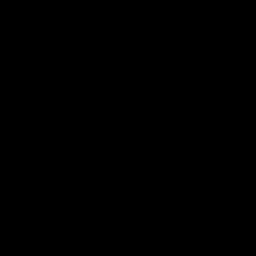

In [ ]:
cv2_imshow(X_test[0])

In [ ]:
np.shape(y_pred)

(12, 256, 256, 3)

In [ ]:
y_pred_argmax = np.argmax(y_pred,axis=3)

In [ ]:
np.shape(y_pred_argmax)

(12, 256, 256)

In [ ]:
np.unique(y_pred_argmax)

array([0, 1, 2])

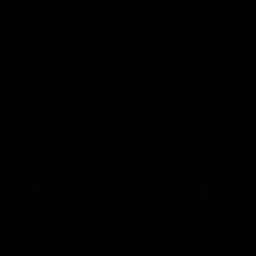

In [ ]:
cv2_imshow(y_pred_argmax[0])

In [ ]:
y_pred_argmax = np.where(y_pred_argmax == 1,76,y_pred_argmax)
y_pred_argmax = np.where(y_pred_argmax == 2,149,y_pred_argmax)



In [ ]:
np.unique(y_pred_argmax)

array([  0,  76, 149])

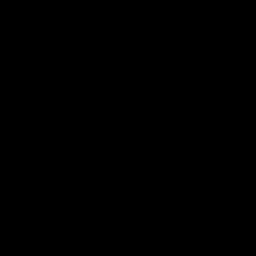

In [ ]:
cv2_imshow(X_test[0])

In [ ]:
cv2_imshow(y_pred_argmax[1])

NameError: ignored

In [ ]:
import numpy as np

new_arr_ele = np.array([15, 25, 44, 56, 74, 2, 19])
result = np.where(new_arr_ele < 19, 69, new_arr_ele)
print("Replace value:",result)

In [ ]:
# ##############################################################
# '''
# Useful blocks to build Unet
# conv - BN - Activation - conv - BN - Activation - Dropout (if enabled)
# '''


# def conv_block(x, filter_size, size, dropout, batch_norm=False):

#     conv = layers.Conv2D(size, (filter_size, filter_size), padding="same")(x)
#     if batch_norm is True:
#         conv = layers.BatchNormalization(axis=3)(conv)
#     conv = layers.Activation("relu")(conv)

#     conv = layers.Conv2D(size, (filter_size, filter_size), padding="same")(conv)
#     if batch_norm is True:
#         conv = layers.BatchNormalization(axis=3)(conv)
#     conv = layers.Activation("relu")(conv)

#     if dropout > 0:
#         conv = layers.Dropout(dropout)(conv)

#     return conv

In [ ]:
np.shape(X_test)

(12, 256, 256, 1)

In [ ]:
# def gating_signal(input, out_size, batch_norm=False):
#     """
#     resize the down layer feature map into the same dimension as the up layer feature map
#     using 1x1 conv
#     :return: the gating feature map with the same dimension of the up layer feature map
#     """
#     x = layers.Conv2D(out_size, (1, 1), padding='same')(input)
#     if batch_norm:
#         x = layers.BatchNormalization()(x)
#     x = layers.Activation('relu')(x)
#     return x

# def attention_block(x, gating, inter_shape):
#     shape_x = K.int_shape(x)
#     shape_g = K.int_shape(gating)

# # Getting the x signal to the same shape as the gating signal
#     theta_x = layers.Conv2D(inter_shape, (2, 2), strides=(2, 2), padding='same')(x)  # 16
#     shape_theta_x = K.int_shape(theta_x)

# # Getting the gating signal to the same number of filters as the inter_shape
#     phi_g = layers.Conv2D(inter_shape, (1, 1), padding='same')(gating)
#     upsample_g = layers.Conv2DTranspose(inter_shape, (3, 3),
#                                  strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]),
#                                  padding='same')(phi_g)  # 16

#     concat_xg = layers.add([upsample_g, theta_x])
#     act_xg = layers.Activation('relu')(concat_xg)
#     psi = layers.Conv2D(1, (1, 1), padding='same')(act_xg)
#     sigmoid_xg = layers.Activation('sigmoid')(psi)
#     shape_sigmoid = K.int_shape(sigmoid_xg)
#     upsample_psi = layers.UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)  # 32

#     y = layers.multiply([upsample_psi, x])

#     result = layers.Conv2D(shape_x[3], (1, 1), padding='same')(y)
#     result_bn = layers.BatchNormalization()(result)
#     return result_bn


In [ ]:
np.shape(X_test)

(12, 256, 256, 1)

In [ ]:
# def Attention_UNet(input_shape, NUM_CLASSES=3, dropout_rate=0.0, batch_norm=True):
#     '''
#     Attention UNet,

#     '''
#     # network structure
#     FILTER_NUM = 64 # number of basic filters for the first layer
#     FILTER_SIZE = 3 # size of the convolutional filter
#     UP_SAMP_SIZE = 2 # size of upsampling filters

#     inputs = layers.Input(input_shape, dtype=tf.float32)

#     # Downsampling layers
#     # DownRes 1, convolution + pooling
#     conv_128 = conv_block(inputs, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
#     pool_64 = layers.MaxPooling2D(pool_size=(2,2))(conv_128)
#     # DownRes 2
#     conv_64 = conv_block(pool_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
#     pool_32 = layers.MaxPooling2D(pool_size=(2,2))(conv_64)
#     # DownRes 3
#     conv_32 = conv_block(pool_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
#     pool_16 = layers.MaxPooling2D(pool_size=(2,2))(conv_32)
#     # DownRes 4
#     conv_16 = conv_block(pool_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
#     pool_8 = layers.MaxPooling2D(pool_size=(2,2))(conv_16)
#     # DownRes 5, convolution only
#     conv_8 = conv_block(pool_8, FILTER_SIZE, 16*FILTER_NUM, dropout_rate, batch_norm)

#     # Upsampling layers
#     # UpRes 6, attention gated concatenation + upsampling + double residual convolution
#     gating_16 = gating_signal(conv_8, 8*FILTER_NUM, batch_norm)
#     att_16 = attention_block(conv_16, gating_16, 8*FILTER_NUM)
#     up_16 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_8)
#     up_16 = layers.concatenate([up_16, att_16], axis=3)
#     up_conv_16 = conv_block(up_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
#     # UpRes 7
#     gating_32 = gating_signal(up_conv_16, 4*FILTER_NUM, batch_norm)
#     att_32 = attention_block(conv_32, gating_32, 4*FILTER_NUM)
#     up_32 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_16)
#     up_32 = layers.concatenate([up_32, att_32], axis=3)
#     up_conv_32 = conv_block(up_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
#     # UpRes 8
#     gating_64 = gating_signal(up_conv_32, 2*FILTER_NUM, batch_norm)
#     att_64 = attention_block(conv_64, gating_64, 2*FILTER_NUM)
#     up_64 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32)
#     up_64 = layers.concatenate([up_64, att_64], axis=3)
#     up_conv_64 = conv_block(up_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
#     # UpRes 9
#     gating_128 = gating_signal(up_conv_64, FILTER_NUM, batch_norm)
#     att_128 = attention_block(conv_128, gating_128, FILTER_NUM)
#     up_128 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64)
#     up_128 = layers.concatenate([up_128, att_128], axis=3)
#     up_conv_128 = conv_block(up_128, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)

#     # 1*1 convolutional layers
#     conv_final = layers.Conv2D(NUM_CLASSES, kernel_size=(1,1))(up_conv_128)
#     conv_final = layers.BatchNormalization(axis=3)(conv_final)
#     conv_final = layers.Activation('softmax')(conv_final)  #Change to softmax for multichannel

#     # Model integration
#     model = models.Model(inputs, conv_final, name="Attention_UNet")
#     return model


In [ ]:
model = Attention_UNet(input_shape, NUM_CLASSES=3, dropout_rate=0.0, batch_norm=True)
model.compile(optimizer='adam', loss=loss_fun, metrics=["accuracy",
                                                        tf.keras.metrics.MeanIoU(3),
                                                        sm.metrics.IOUScore(threshold=0.5),
                                                        tf.keras.metrics.Precision(),
                                                        tf.keras.metrics.Recall(),
                                                        [jacard_coef],
                                                        [dice_coef],
                                                        sm.metrics.FScore(threshold=0.5)])
model.summary()


In [ ]:
np.shape(X_test)

(12, 256, 256, 1)

In [ ]:
log_csv = CSVLogger('/content/drive/MyDrive/my_logs.csv', separator=',', append=True)
early_stop = EarlyStopping(monitor='val_dice_coef', patience=3, verbose=1)
file_path = '/content/drive/MyDrive/0_epoch_weights/epochno-{epoch:04d}.hdf5'
checkpoint = ModelCheckpoint(file_path, verbose=1,monitor="val_dice_coef", save_best_only=True, mode='max',save_freq=1)


tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir='/content/drive/MyDrive/0ten/Tensorboard_logs',
    histogram_freq=1,
    write_graph=True,
    write_images=False,
    write_steps_per_second=False,
    update_freq='epoch',
    profile_batch=0,
    embeddings_freq=0,
    embeddings_metadata=None,
)

callbacks_list = [log_csv,checkpoint,tensorboard_callback,early_stop]

In [ ]:
np.shape(X_test)

(12, 256, 256, 1)

In [ ]:
# from keras.models import load_model

In [ ]:
from keras.models import load_model
model = load_model('/content/drive/MyDrive/0_epoch_weights/epochno-0003.hdf5',custom_objects={'focal_loss':loss_fun,
                                                                                 'iou_score':sm.metrics.IOUScore(threshold=0.5),
                                                                                 "jacard_coef":jacard_coef,
                                                                                 "dice_coef":dice_coef,
                                                                                 'f1-score':sm.metrics.FScore(threshold=0.5)})


In [ ]:
#IOU
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)


In [ ]:
y_pred

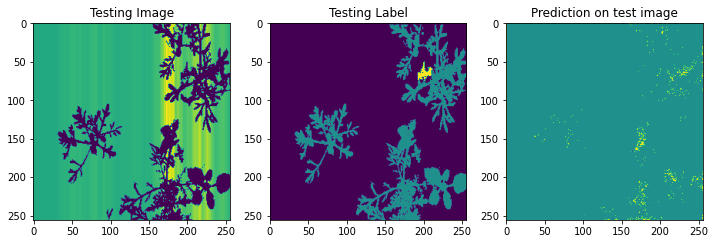

In [ ]:
# Predict on a few images
#model = get_model()
#model.load_weights('???.hdf5')
import random
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0])
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img)
plt.show()



In [ ]:
history = model.fit(X_train,y_train_cat,
                    batch_size = 8,
                    verbose=1,
                    epochs=20,
                    validation_data=(X_val,y_val_cat),
                    callbacks=[callbacks_list],
                    shuffle=False)

In [ ]:
model.save("/content/drive/MyDrive/0_epoch_weights/ayush.h5")

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure()
plt.plot(history.epoch, loss, 'r', label='Training loss')
plt.plot(history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

NameError: ignored

In [ ]:
img = model.predict(X_test)

In [ ]:
y_pred_argmax=np.argmax(img, axis=3)


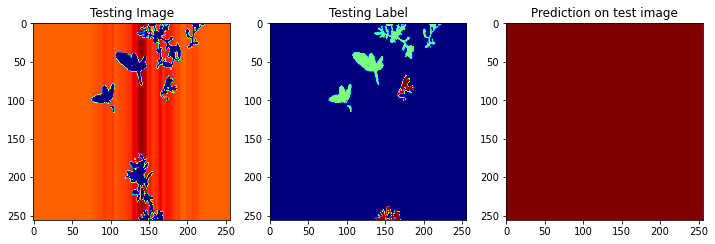

In [ ]:
# Predict on a few images
#model = get_model()
model.load_weights('/content/drive/MyDrive/0_epoch_weights/ayush.h5')
import random
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0],cmap='jet')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0],cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap="jet")
plt.show()



In [ ]:
tf.model.save("/content/drive/MyDrive/0_epoch_weights/model.h5")

AttributeError: ignored

AttributeError: ignored

In [ ]:
# model.fit(x_train, y_train, initial_epoch=9, epochs=19, callbacks=[Tensorboard()]